# COGS 108 - Final Project 

# Overview

In this project, I analyzed the relationship between the income in an area and the number of critical violations in that area. To accomplish this, I used the inspections and the zipcodes datasets, cleaned and selected the data that I intended to use, and joined both datasets based on zipcode, resulting in a dataset that contained average number of critical violations per zipcode area as well as the median income statistics for the area. I then used this dataframe to plot scatterplots as well as analyze linear models in an attempt to find a relationship. However, after analyzing the linear models, I found that there was no clear relationship between the variables, contradicting my prediction that there would be a negative linear relationship between them.

# Name & PID

- Name: Ruben Gonzalez
- PID: A13777913

# Research Question

Is income related to the number of critical violations restaurants receive in an area? 

## Background and Prior Work

- 1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/

This first article observes the relationship of inspection frquency and sociodemographic factors with health violations in restaurants. Rather than focusing on their findings in inspection frequency, I'll focus on the impact of sociodemographic factor on health violations. They collected census data for each restaurant neighborhood that they analyzed, similar to what I will be doing with the zipcode areas but I'll be focusing on income data. They used regression techniques in order to find a relationship between both variables, which leads me to believe that using regression techniques would be beneficial for my project.

- 2) https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-019-6546-2

This second article focuses on the variation of food quality based on the income of households. This relates to my project in that I also seek in finding some relationship based on the income of houselds, only over a bigger area. In this study, they collected food purchase over two weeks from 202 households. They ended up concluding that lower income households tend to purchase less healthful foods than higher income households. This might lead me to believe that I can find a similar relationship, where it might be posssible that places that sell less healthful foods tend to have more health violations.

# Hypothesis


I believe that there is a relationship between the income in an area and the number of critical violations for restaurants in that area. I specifically believe that the relationship is linear, where the number of critical violations increases as the income in an area decreases. 

# Dataset(s)

- Dataset Name: Inspections.csv
- Number of observations: 3
This dataset contains information about the individual inspections done to the different restaurants of the NC area we're analyzing. I ended up using the zip, hsisid, num_critical columns to obtain information about the average number of critical violations for each zipcode area.

- Dataset Name: zipcodes.csv
- Number of observations: 4
This dataset contains zipcode information for NC, including a variety income statistics for each zipcode. I ended using the zip column, as well as the three columns related to income, in order to be able to find a relationship with the number of critical violations for that area.

I plan to combine these datasets based on their zipcode.

# Setup

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Data Cleaning

### Inspections.csv dataset cleaning

I will be looking at the inspections dataset in order to get a hold of the critical violations data. First, I will filter the data by only looking at the facilities that are considered as restaurants. Then, I will select the columns that will be helpful for our analysis. I won't be using the names of the dataset, since they are not necessary for any analysis, nor will I be using them to join this dataset with others. Instead of that, I will use the hsisid column to identify specific restaurants. After that I will drop all rows where there are null entries. Then I groupby the zip and the hsisid, then get the sum of the critical violations per restaurant. Finally, I drop the hsisid column and get the mean number of critical violations per zipcode. The dataset is displayed to give the reader an idea about the data. 

In [2]:
# We only want the restaurants in the inspection dataset
df_inspections = pd.read_csv('Project_Files/inspections.csv')
df_inspections = df_inspections[df_inspections['facilitytype'] == 'Restaurant']

# We don't want to use all columns, so we'll select the columns that we may need
df_inspections = df_inspections[['hsisid','zip', 'num_critical']]

# Drop all null rows
df_inspections = df_inspections.dropna()

# Group by the hsisid and zip, then sum the critical violations to get the total per restaurant
df_inspections = df_inspections.groupby(['hsisid', 'zip'], as_index=False).sum()

# Drop the hsisid column and then group by the zip code to get the average number of critical violations per area
df_inspections = df_inspections[['zip', 'num_critical']]
df_inspections = df_inspections.groupby('zip', as_index=False).mean()

# Display the dataframe
df_inspections.head()

,zip,num_critical
0,27501,36.000000
1,27502,19.909091
2,27511,20.789116
3,27512,27.000000
4,27513,28.640000


### zipcodes.csv dataset cleaning

The zipcodes dataset not includes the zipcodes of the area we are analyzing, but it also includes statistics about the income of households and people living in that area. Therefore, when we convert the dataset to a dataframe, we will select the columns related to income alongside the zip column.

In [3]:
# Get the dataframe and select any columns related to income
df_zip = pd.read_csv('Project_Files/zipcodes.csv')
df_zip = df_zip[['zip', 'median_family_income_dollars', 'median_household_income_dollars', 'per_capita_income_dollars']]

# We'll want to rename the columns to either correct them or make them more readable
df_zip.columns = ['zip', 'median_family_income', 'median_household_income', 'per_capita_income']

# Display
df_zip.head()

,zip,median_family_income,median_household_income,per_capita_income
0,27501,59408,51121,21631
1,27502,109891,95857,36763
2,27511,82292,67392,33139
3,27513,109736,87262,41232
4,27518,125432,98247,49865


### Mergind the zipcodes dataset with the inspections dataset

At this point, I have to merge the datasets in order to combine the number of violations per zipcode with the income data per zipcode.

In [4]:
# Merge the the inspections and zipcode dataframses
df_analysis = pd.merge(df_inspections, df_zip, on='zip')
df_analysis = df_analysis.sort_values(['num_critical'], ascending=False).reset_index(drop=True)

df_analysis.head()

,zip,num_critical,median_family_income,median_household_income,per_capita_income
0,27501,36.000000,59408,51121,21631
1,27562,34.000000,71161,61097,31161
2,27526,32.315068,74666,66025,28074
3,27513,28.640000,109736,87262,41232
4,27592,27.000000,66160,56747,23355


Finally we are able to do analysis on this dataframe.

# Data Analysis & Results

We will compare the relationship between the three types of income data we have against the average number of critical violations.

In [5]:
df_analysis.corr()

,zip,num_critical,median_family_income,median_household_income,per_capita_income
zip,1.000000,-0.240776,-0.178128,-0.370389,0.034761
num_critical,-0.240776,1.000000,-0.186746,-0.161487,-0.164433
median_family_income,-0.178128,-0.186746,1.000000,0.879418,0.898936
median_household_income,-0.370389,-0.161487,0.879418,1.000000,0.717270
per_capita_income,0.034761,-0.164433,0.898936,0.717270,1.000000


Looking at the correlation we can tell that the variables are negatively correlated with the number of critical violations. However, the correlation seems to be relatively small. We'll analyze this further by looking at scatterplots of the variables as well as applying linear models to them.

### Median Family Income Dollars vs Num Critical

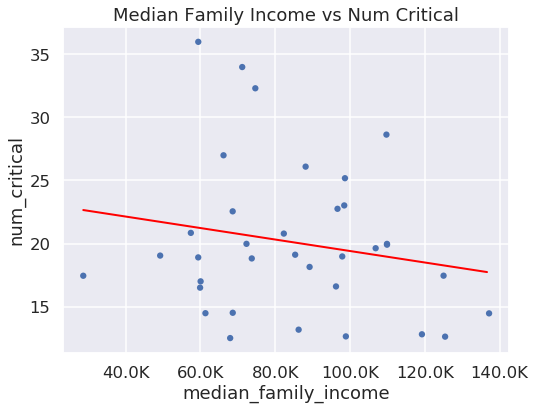

In [6]:
# We have to setup a line in order to see any sort of linearity
a1, b1 = np.polyfit(df_analysis['median_family_income'], df_analysis['num_critical'], 1)
fam_incomes = np.arange(df_analysis['median_family_income'].min(), df_analysis['median_family_income'].max(), 1000)
pred_fam_income = a1 * fam_incomes + b1

# Set the figure size
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)

p1 = sns.scatterplot(x=df_analysis['median_family_income'],y=df_analysis['num_critical'], data=df_analysis, alpha=1, edgecolor='none', s=40, ax=ax)
p1.set_title('Median Family Income vs Num Critical')
xlabels = ['{:}'.format(x) + 'K' for x in p1.get_xticks()/1000]
p1.set_xticklabels(xlabels)
plt.plot(fam_incomes, pred_fam_income, color='red', linewidth=2, label='Model')

Looking at the graph, we can see some sort of linear relationship, although it is little. The line negatively sloped as expected. We'll further analyze it by doing some linear regression on it.

In [7]:
outcome_1, predictors_1 = patsy.dmatrices("num_critical ~ median_family_income", df_analysis)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:           num_critical   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.192
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.283
Time:                        23:33:32   Log-Likelihood:                -111.27
No. Observations:                  35   AIC:                             226.5
Df Residuals:                      33   BIC:                             229.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               23.9616 

The p value here is not so big, but it is not as small as we would like. The R-squared value is also quite small. Therefore, we can't see this linear model as a good predictor and see no clear relation between the variables.

### Median Household Income vs Num Critical

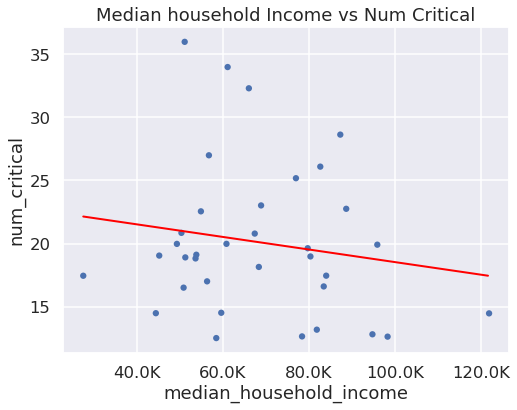

In [8]:
# We have to setup a line in order to see any sort of linearity
a2, b2 = np.polyfit(df_analysis['median_household_income'], df_analysis['num_critical'], 1)
household_incomes = np.arange(df_analysis['median_household_income'].min(), df_analysis['median_household_income'].max(), 1000)
pred_household_income = a2 * household_incomes + b2

# Set the figure size
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)

p2 = sns.scatterplot(x=df_analysis['median_household_income'],y=df_analysis['num_critical'], data=df_analysis, alpha=1, edgecolor='none', s=40, ax=ax)
p2.set_title('Median household Income vs Num Critical')
xlabels = ['{:}'.format(x) + 'K' for x in p2.get_xticks()/1000]
p2.set_xticklabels(xlabels)
plt.plot(household_incomes, pred_household_income, color='red', linewidth=2, label='Model')

Plotted data is similar to the family income data. Dots show a very slight tendency downward and the line has a negative slope as predicted.

In [9]:
outcome_2, predictors_2 = patsy.dmatrices("num_critical ~ median_household_income", df_analysis)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:           num_critical   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8836
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.354
Time:                        23:33:33   Log-Likelihood:                -111.42
No. Observations:                  35   AIC:                             226.8
Df Residuals:                      33   BIC:                             230.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

The p value here is even bigger than the one of the previous variable and the R-squared is even smaller than the previous. Therefore, we once again fail to use this model as a good predictor and fail to see any clear relationship between both variables.

### Per Capita Income vs Num Critical

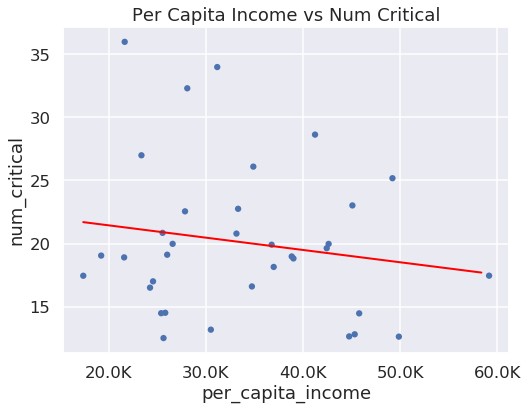

In [10]:
# We have to setup a line in order to see any sort of linearity
a3, b3 = np.polyfit(df_analysis['per_capita_income'], df_analysis['num_critical'], 1)
percapita_incomes = np.arange(df_analysis['per_capita_income'].min(), df_analysis['per_capita_income'].max(), 1000)
pred_percapita_income = a3 * percapita_incomes + b3

# Set the figure size
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)

p3 = sns.scatterplot(x=df_analysis['per_capita_income'],y=df_analysis['num_critical'], data=df_analysis, alpha=1, edgecolor='none', s=40, ax=ax)
p3.set_title('Per Capita Income vs Num Critical')
xlabels = ['{:}'.format(x) + 'K' for x in p3.get_xticks()/1000]
p3.set_xticklabels(xlabels)
plt.plot(percapita_incomes, pred_percapita_income, color='red', linewidth=2, label='Model')

Once again the line tends to slope negatively as expectected. The data seems to be more spread out than the previous ones however.

In [11]:
outcome_3, predictors_3 = patsy.dmatrices("num_critical ~ per_capita_income", df_analysis)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:           num_critical   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9171
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.345
Time:                        23:33:33   Log-Likelihood:                -111.41
No. Observations:                  35   AIC:                             226.8
Df Residuals:                      33   BIC:                             229.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            23.3928      3.57

With a similar p-value and R-squared value as the previous model, we once again fail to see a clear relationship between the variables.

# Ethics & Privacy

With regards to the ethics regarding the data of the project, there should be no problem as it was provided to us for the purpose of this project. The biggest concern that I can think of with the dataset is that even though it only focuses on a specific area, it does not contain all of the zipcodes included in the other datasets. This might lead to an innaccurate representation of the overall population in the state, that led to omitting some data that could have led to different results. With regards to my displaying of the data, I made sure that the report does not display any individual information of each restaurant, or something that might identify an individual restaurant. All calculations were made before actually displaying the general zip code data. 

# Conclusion & Discussion

The goal of my project was to find a relationship between the income in an area and the the number of critical violations in that area. I used a dataset that contained information about individual inspections in NC, as well as a dataset that contained income data for different zipcode areas in NC. I ended up modifying the inspection dataset so as to display the average number of critical inspections per zipcode and joined it with the area income dataset in order to go forth with my analysis. I ended up using scatterplots to analyze the relationship between the different income variables and the number of critical violations, as well as linear regression techniques. Even though I ended up finding a negative correlation between the variables, it was considerably small and with the rest of the result of the analysis, I was not able to find a relationship between any of the income variables and critical violations for that area, leading me to conclude that there was no relationship to be found. 

With regards to the limitations in this project, I can say that lack of a complete dataset that included all zipcodes in the state of NC might have led to an incomplete observation of the problem. Also, the way the data was recorded prevented me from being able to confidently go forth with a different type of question/problem, most specifically with how names were recorded in the yelp dataset and the inspection dataset. Concerning the impact of this project is mostly related to fully answering the question about income relationship with health inspections. Considering there can be other ways to approach this problem, a greater thorough analysis could maybe uncover injustices in the resources some communities can have with regards to the inspections.